In [2]:
bc_data <- read.table("data/breast-cancer-wisconsin.data.txt", 
                      header = FALSE, 
                      sep = ",")
colnames(bc_data) <- c("sample_code_number", 
                       "clump_thickness", 
                       "uniformity_of_cell_size", 
                       "uniformity_of_cell_shape", 
                       "marginal_adhesion", 
                       "single_epithelial_cell_size", 
                       "bare_nuclei", 
                       "bland_chromatin", 
                       "normal_nucleoli", 
                       "mitosis", 
                       "classes")

bc_data$classes <- ifelse(bc_data$classes == "2", "benign",
                          ifelse(bc_data$classes == "4", "malignant", NA))

In [5]:
bc_data[bc_data == "?"] <- NA

length(which(is.na(bc_data)))


[1] 16

In [6]:
nrow(bc_data)

[1] 699

In [11]:
nrow(bc_data[is.na(bc_data), ])


[1] 16

In [14]:
install.packages('mice')

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [15]:
# impute missing data
library(mice)

bc_data[,2:10] <- apply(bc_data[, 2:10], 2, function(x) as.numeric(as.character(x)))
dataset_impute <- mice(bc_data[, 2:10],  print = FALSE)
bc_data <- cbind(bc_data[, 11, drop = FALSE], mice::complete(dataset_impute, 1))

bc_data$classes <- as.factor(bc_data$classes)

# how many benign and malignant cases are there?
summary(bc_data$classes)

Loading required package: lattice


benign malignant 
      458       241

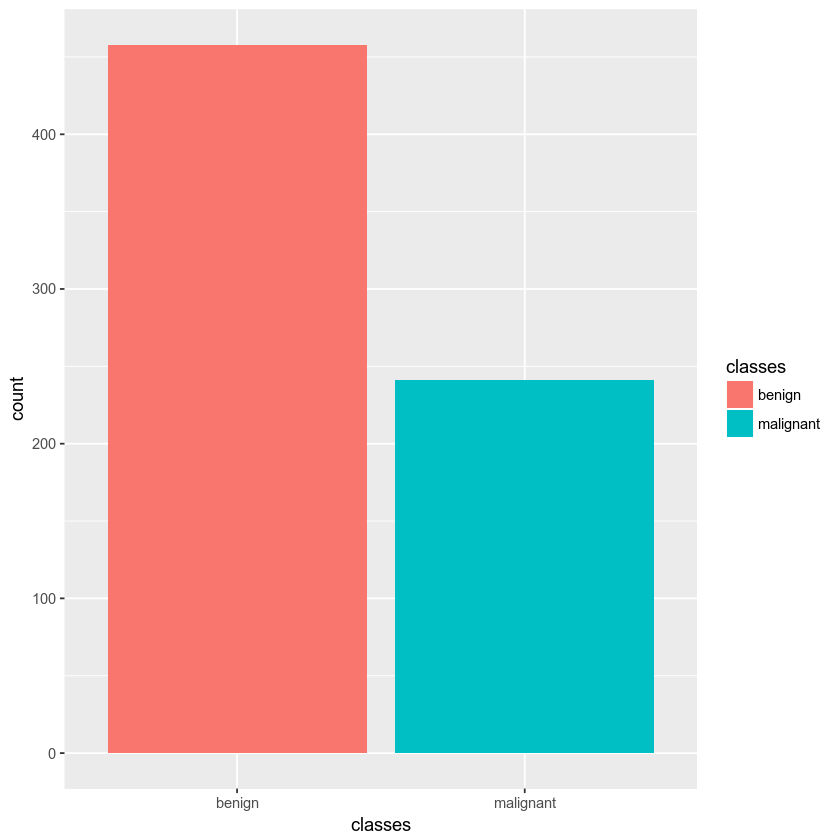

In [17]:
library(ggplot2)

ggplot(bc_data, aes(x = classes, fill = classes)) +
  geom_bar()

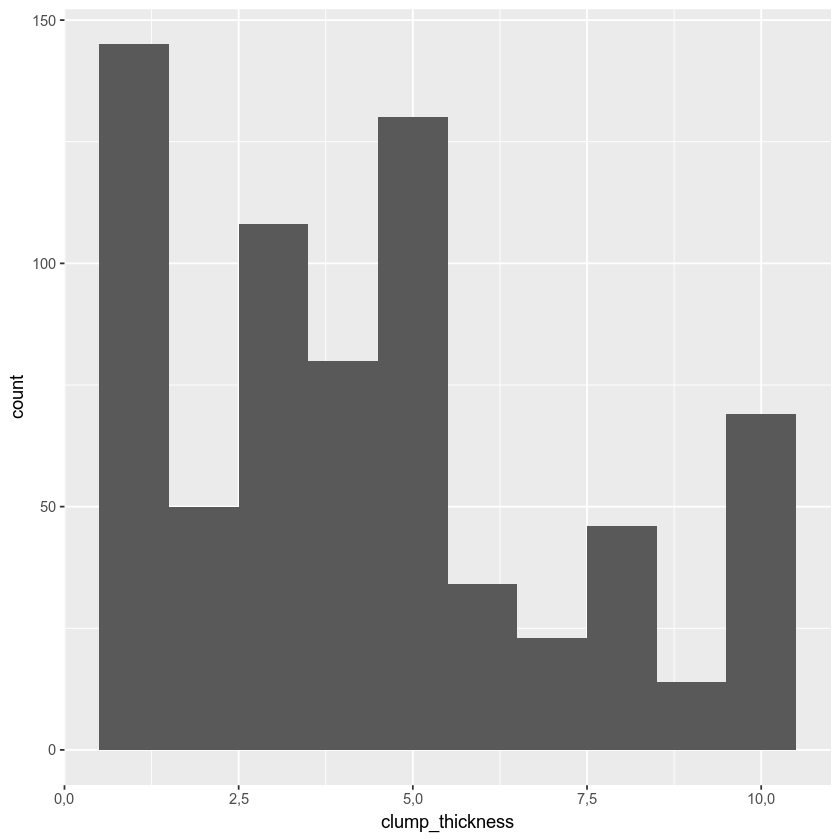

In [18]:
#i'll ignore the unbalance of data, and implement this on other study.
ggplot(bc_data, aes(x = clump_thickness)) +
  geom_histogram(bins = 10)

In [25]:
install.packages(c('ellipse'))
source("https://bioconductor.org/biocLite.R")
biocLite("pcaGoPromoter")

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Bioconductor version 3.6 (BiocInstaller 1.28.0), ?biocLite for help
A new version of Bioconductor is available after installing the most recent
  version of R; see http://bioconductor.org/install
BioC_mirror: https://bioconductor.org
Using Bioconductor 3.6 (BiocInstaller 1.28.0), R 3.4.3 (2017-11-30).
Installing package(s) ‘pcaGoPromoter’
also installing the dependencies ‘bit’, ‘prettyunits’, ‘zlibbioc’, ‘bit64’, ‘blob’, ‘DBI’, ‘memoise’, ‘plogr’, ‘BiocGenerics’, ‘S4Vectors’, ‘IRanges’, ‘XVector’, ‘Biobase’, ‘RSQLite’, ‘Biostrings’, ‘AnnotationDbi’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Old packages: 'BH', 'bindr', 'bindrcpp', 'broom', 'callr', 'caret',
  'checkpoint', 'clipr', 'cluster', 'curl', 'CVST', 'data.table', 'dbplyr',
  'ddalpha', 'digest', 'doParallel', 'dplyr', 'DRR', 'ellipse', 'f

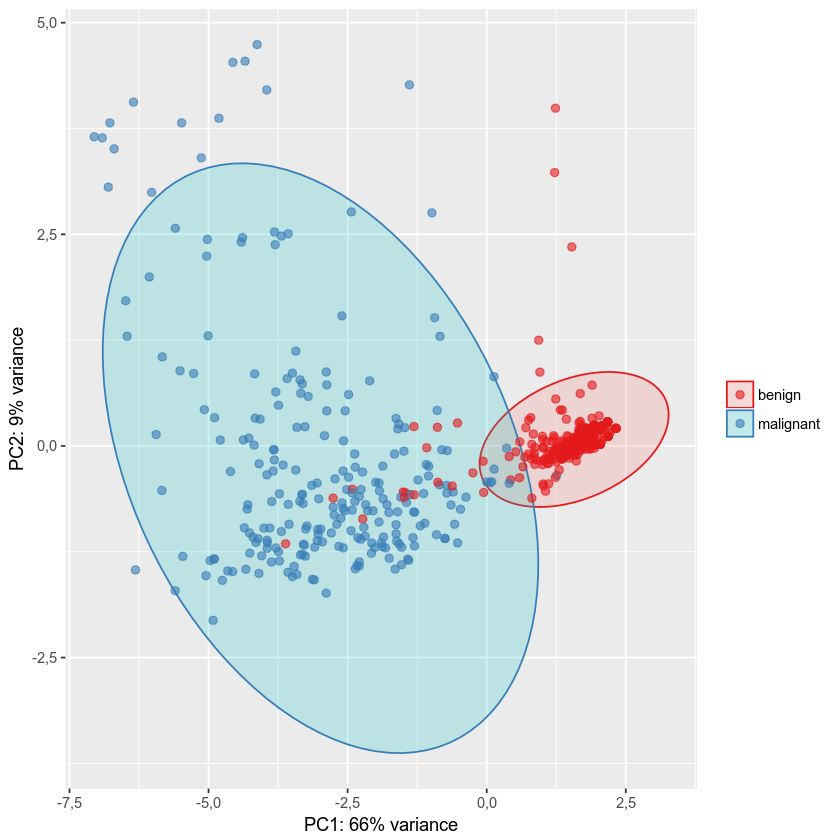

In [27]:
library(pcaGoPromoter)
library(ellipse)

# perform pca and extract scores
pcaOutput <- pca(t(bc_data[, -1]), printDropped = FALSE, scale = TRUE, center = TRUE)
pcaOutput2 <- as.data.frame(pcaOutput$scores)
  
# define groups for plotting
pcaOutput2$groups <- bc_data$classes
  
centroids <- aggregate(cbind(PC1, PC2) ~ groups, pcaOutput2, mean)

conf.rgn  <- do.call(rbind, lapply(unique(pcaOutput2$groups), function(t)
  data.frame(groups = as.character(t),
             ellipse(cov(pcaOutput2[pcaOutput2$groups == t, 1:2]),
                   centre = as.matrix(centroids[centroids$groups == t, 2:3]),
                   level = 0.95),
             stringsAsFactors = FALSE)))
    
ggplot(data = pcaOutput2, aes(x = PC1, y = PC2, group = groups, color = groups)) + 
    geom_polygon(data = conf.rgn, aes(fill = groups), alpha = 0.2) +
    geom_point(size = 2, alpha = 0.6) + 
    scale_color_brewer(palette = "Set1") +
    labs(color = "",
         fill = "",
         x = paste0("PC1: ", round(pcaOutput$pov[1], digits = 2) * 100, "% variance"),
         y = paste0("PC2: ", round(pcaOutput$pov[2], digits = 2) * 100, "% variance")) 

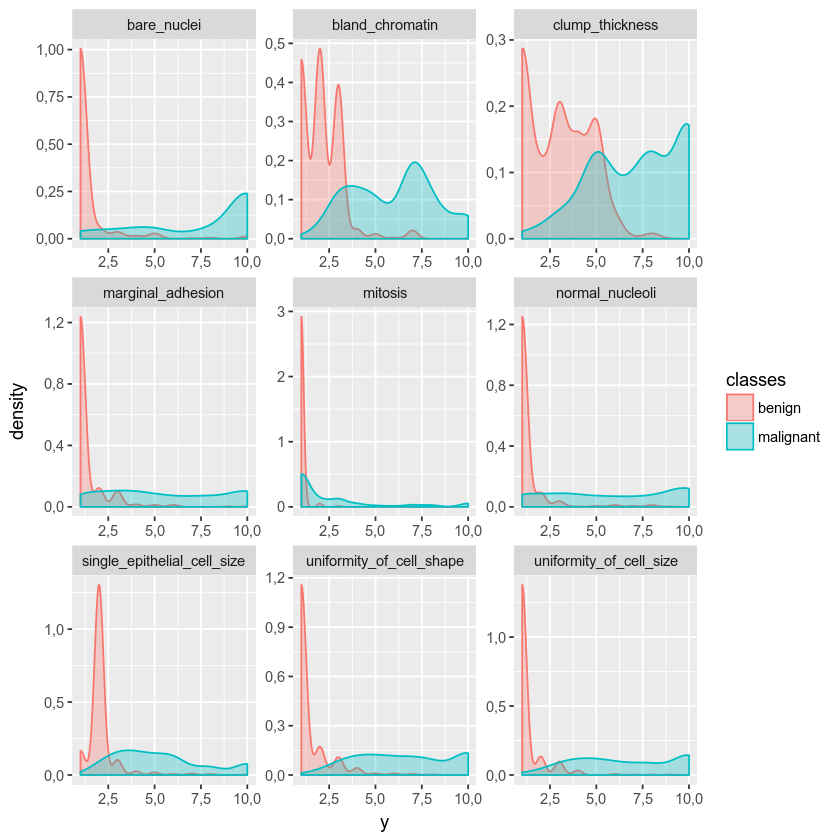

In [29]:
library(tidyr)

gather(bc_data, x, y, clump_thickness:mitosis) %>%
  ggplot(aes(x = y, color = classes, fill = classes)) +
    geom_density(alpha = 0.3) +
    facet_wrap( ~ x, scales = "free", ncol = 3)

In [30]:
# configure multicore
library(doParallel)
cl <- makeCluster(detectCores())
registerDoParallel(cl)

Loading required package: foreach
Loading required package: iterators


In [31]:
library(caret)


In [32]:
set.seed(42)
index <- createDataPartition(bc_data$classes, p = 0.7, list = FALSE)
train_data <- bc_data[index, ]
test_data  <- bc_data[-index, ]

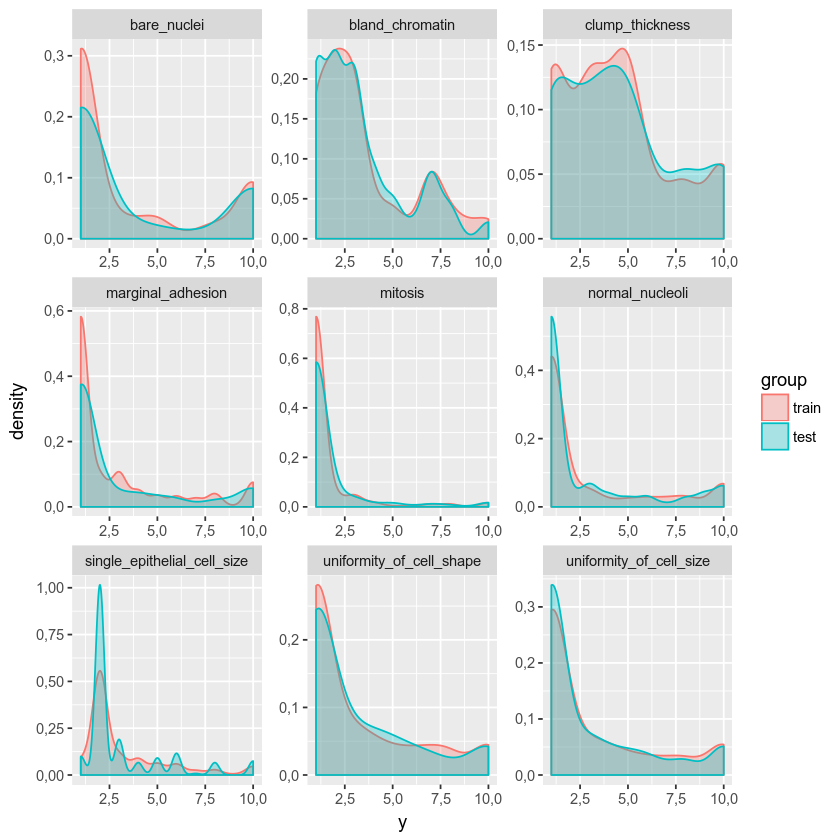

In [35]:
library(dplyr)

rbind(data.frame(group = "train", train_data),
      data.frame(group = "test", test_data)) %>%
  gather(x, y, clump_thickness:mitosis) %>%
  ggplot(aes(x = y, color = group, fill = group)) +
    geom_density(alpha = 0.3) +
    facet_wrap( ~ x, scales = "free", ncol = 3)

In [36]:
set.seed(42)
model_glm <- caret::train(clump_thickness ~ .,
                          data = train_data,
                          method = "glm",
                          preProcess = c("scale", "center"),
                          trControl = trainControl(method = "repeatedcv", 
                                                  number = 10, 
                                                  repeats = 10, 
                                                  savePredictions = TRUE, 
                                                  verboseIter = FALSE))

In [37]:
model_glm

Generalized Linear Model 

490 samples
  9 predictor

Pre-processing: scaled (9), centered (9) 
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 440, 440, 441, 441, 442, 441, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  1,977263  0,5024431  1,638332


In [38]:
predictions <- predict(model_glm, test_data)


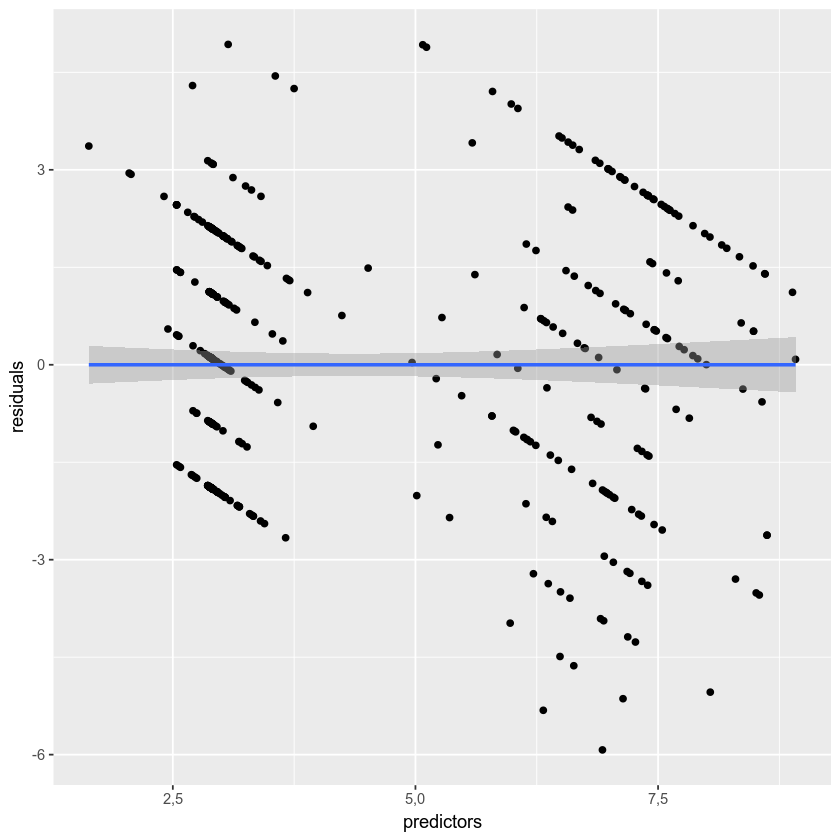

In [39]:
data.frame(residuals = resid(model_glm),
           predictors = model_glm$finalModel$linear.predictors) %>%
  ggplot(aes(x = predictors, y = residuals)) +
    geom_jitter() +
    geom_smooth(method = "lm")

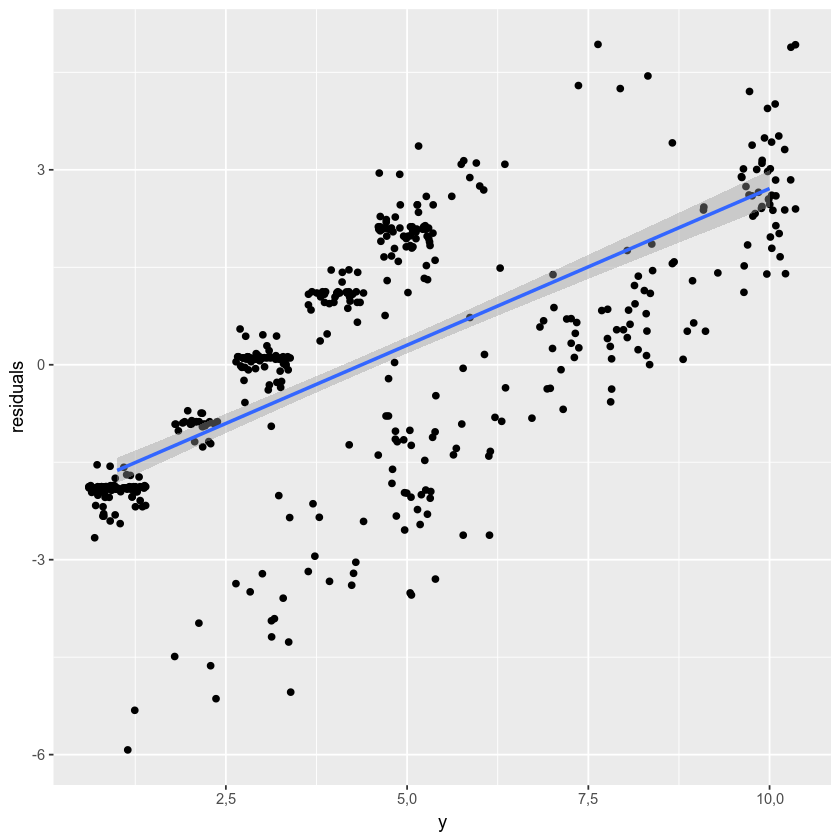

In [40]:
data.frame(residuals = resid(model_glm),
           y = model_glm$finalModel$y) %>%
  ggplot(aes(x = y, y = residuals)) +
    geom_jitter() +
    geom_smooth(method = "lm")

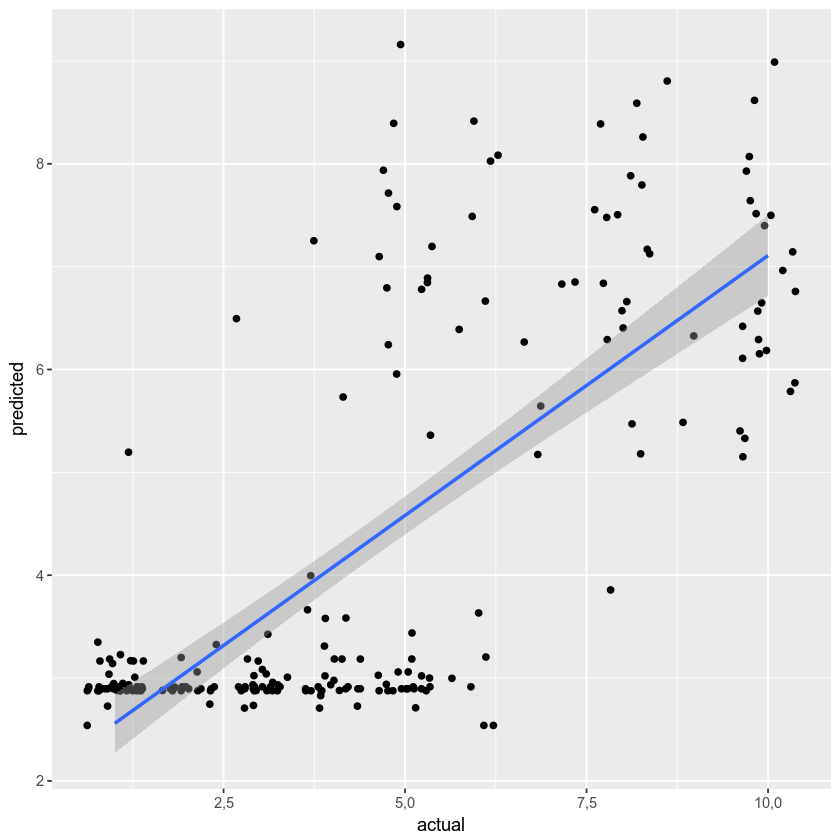

In [41]:
data.frame(actual = test_data$clump_thickness,
           predicted = predictions) %>%
  ggplot(aes(x = actual, y = predicted)) +
    geom_jitter() +
    geom_smooth(method = "lm")

In [43]:
install.packages('rpart.plot')

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


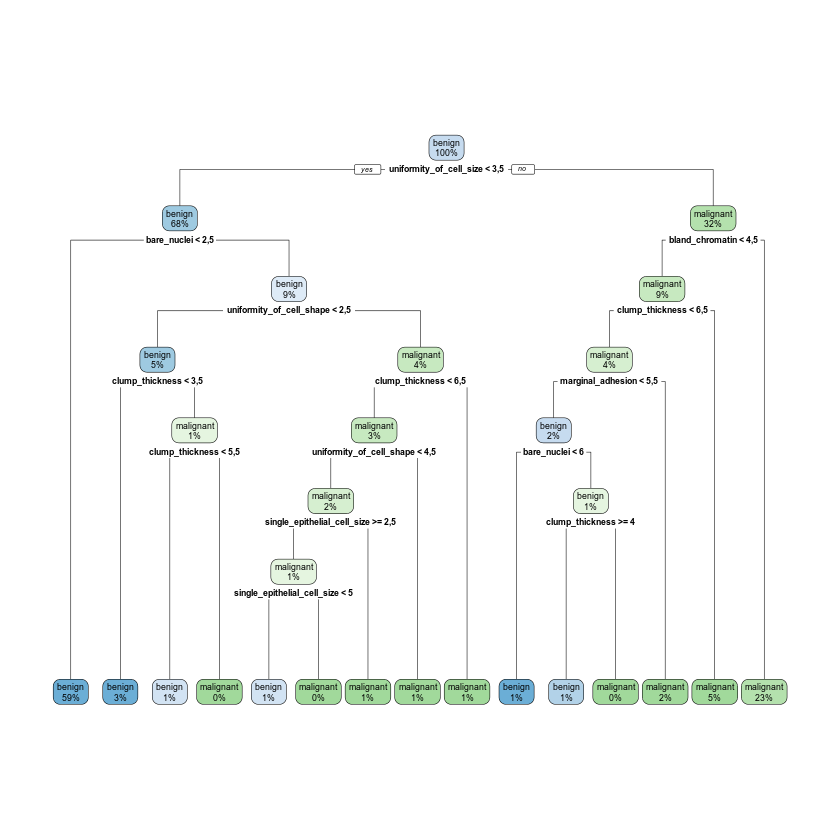

In [44]:
library(rpart)
library(rpart.plot)

set.seed(42)
fit <- rpart(classes ~ .,
            data = train_data,
            method = "class",
            control = rpart.control(xval = 10, 
                                    minbucket = 2, 
                                    cp = 0), 
             parms = list(split = "information"))

rpart.plot(fit, extra = 100)